In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [3]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Microbiota Status Classification/health_data_10000_chunk.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all')

df_info, df_head, df_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Height (cm)                                       10000 non-null  int64  
 1   Weight (kg)                                       10000 non-null  int64  
 2   BMI                                               10000 non-null  float64
 3   Medical conditions                                10000 non-null  object 
 4   Medications in use                                10000 non-null  object 
 5   Residential Address                               10000 non-null  object 
 6   Previous gastrointestinal issues                  10000 non-null  bool   
 7   Family history of diseases                        10000 non-null  object 
 8   Previous surgeries                                10000 non-null  object 
 9   Previous therapies

(None,
    Height (cm)  Weight (kg)   BMI    Medical conditions  \
 0          173          120  40.1      Diabetes, Anemia   
 1          183          110  32.8        Asthma, Anemia   
 2          160          111  43.4  Hypertension, Asthma   
 3          177           75  23.9        Anemia, Asthma   
 4          170           97  33.6  Hypertension, Asthma   
 
        Medications in use                                Residential Address  \
 0  Aspirin, Levothyroxine  17761 Coleman Coves Suite 307\nWest Ryan, FL 8...   
 1     Lisinopril, Aspirin       11610 Thompson Trail\nSouth Steven, CA 97229   
 2     Aspirin, Lisinopril      89841 Nguyen Station\nNew Jennafurt, WA 05070   
 3   Metformin, Lisinopril               194 Adam Alley\nRoachville, CO 73756   
 4     Lisinopril, Insulin  420 Griffin Rest Suite 963\nNew Allisonburgh, ...   
 
    Previous gastrointestinal issues   Family history of diseases  \
 0                              True             Cancer, Diabetes   
 1   

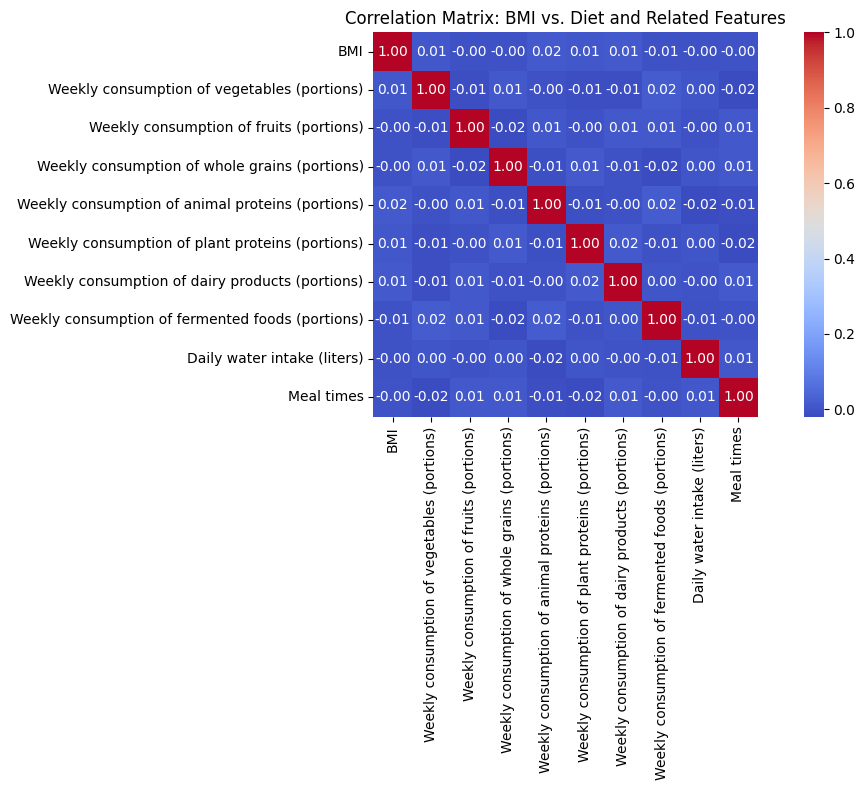

In [4]:
# Select numerical dietary and BMI-related features
diet_bmi_features = [
    'BMI',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Weekly consumption of animal proteins (portions)',
    'Weekly consumption of plant proteins (portions)',
    'Weekly consumption of dairy products (portions)',
    'Weekly consumption of fermented foods (portions)',
    'Daily water intake (liters)',
    'Meal times'
]

# Calculate the correlation matrix
correlation_matrix = df[diet_bmi_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix: BMI vs. Diet and Related Features")
plt.tight_layout()
plt.show()


Detect outliers and missing values


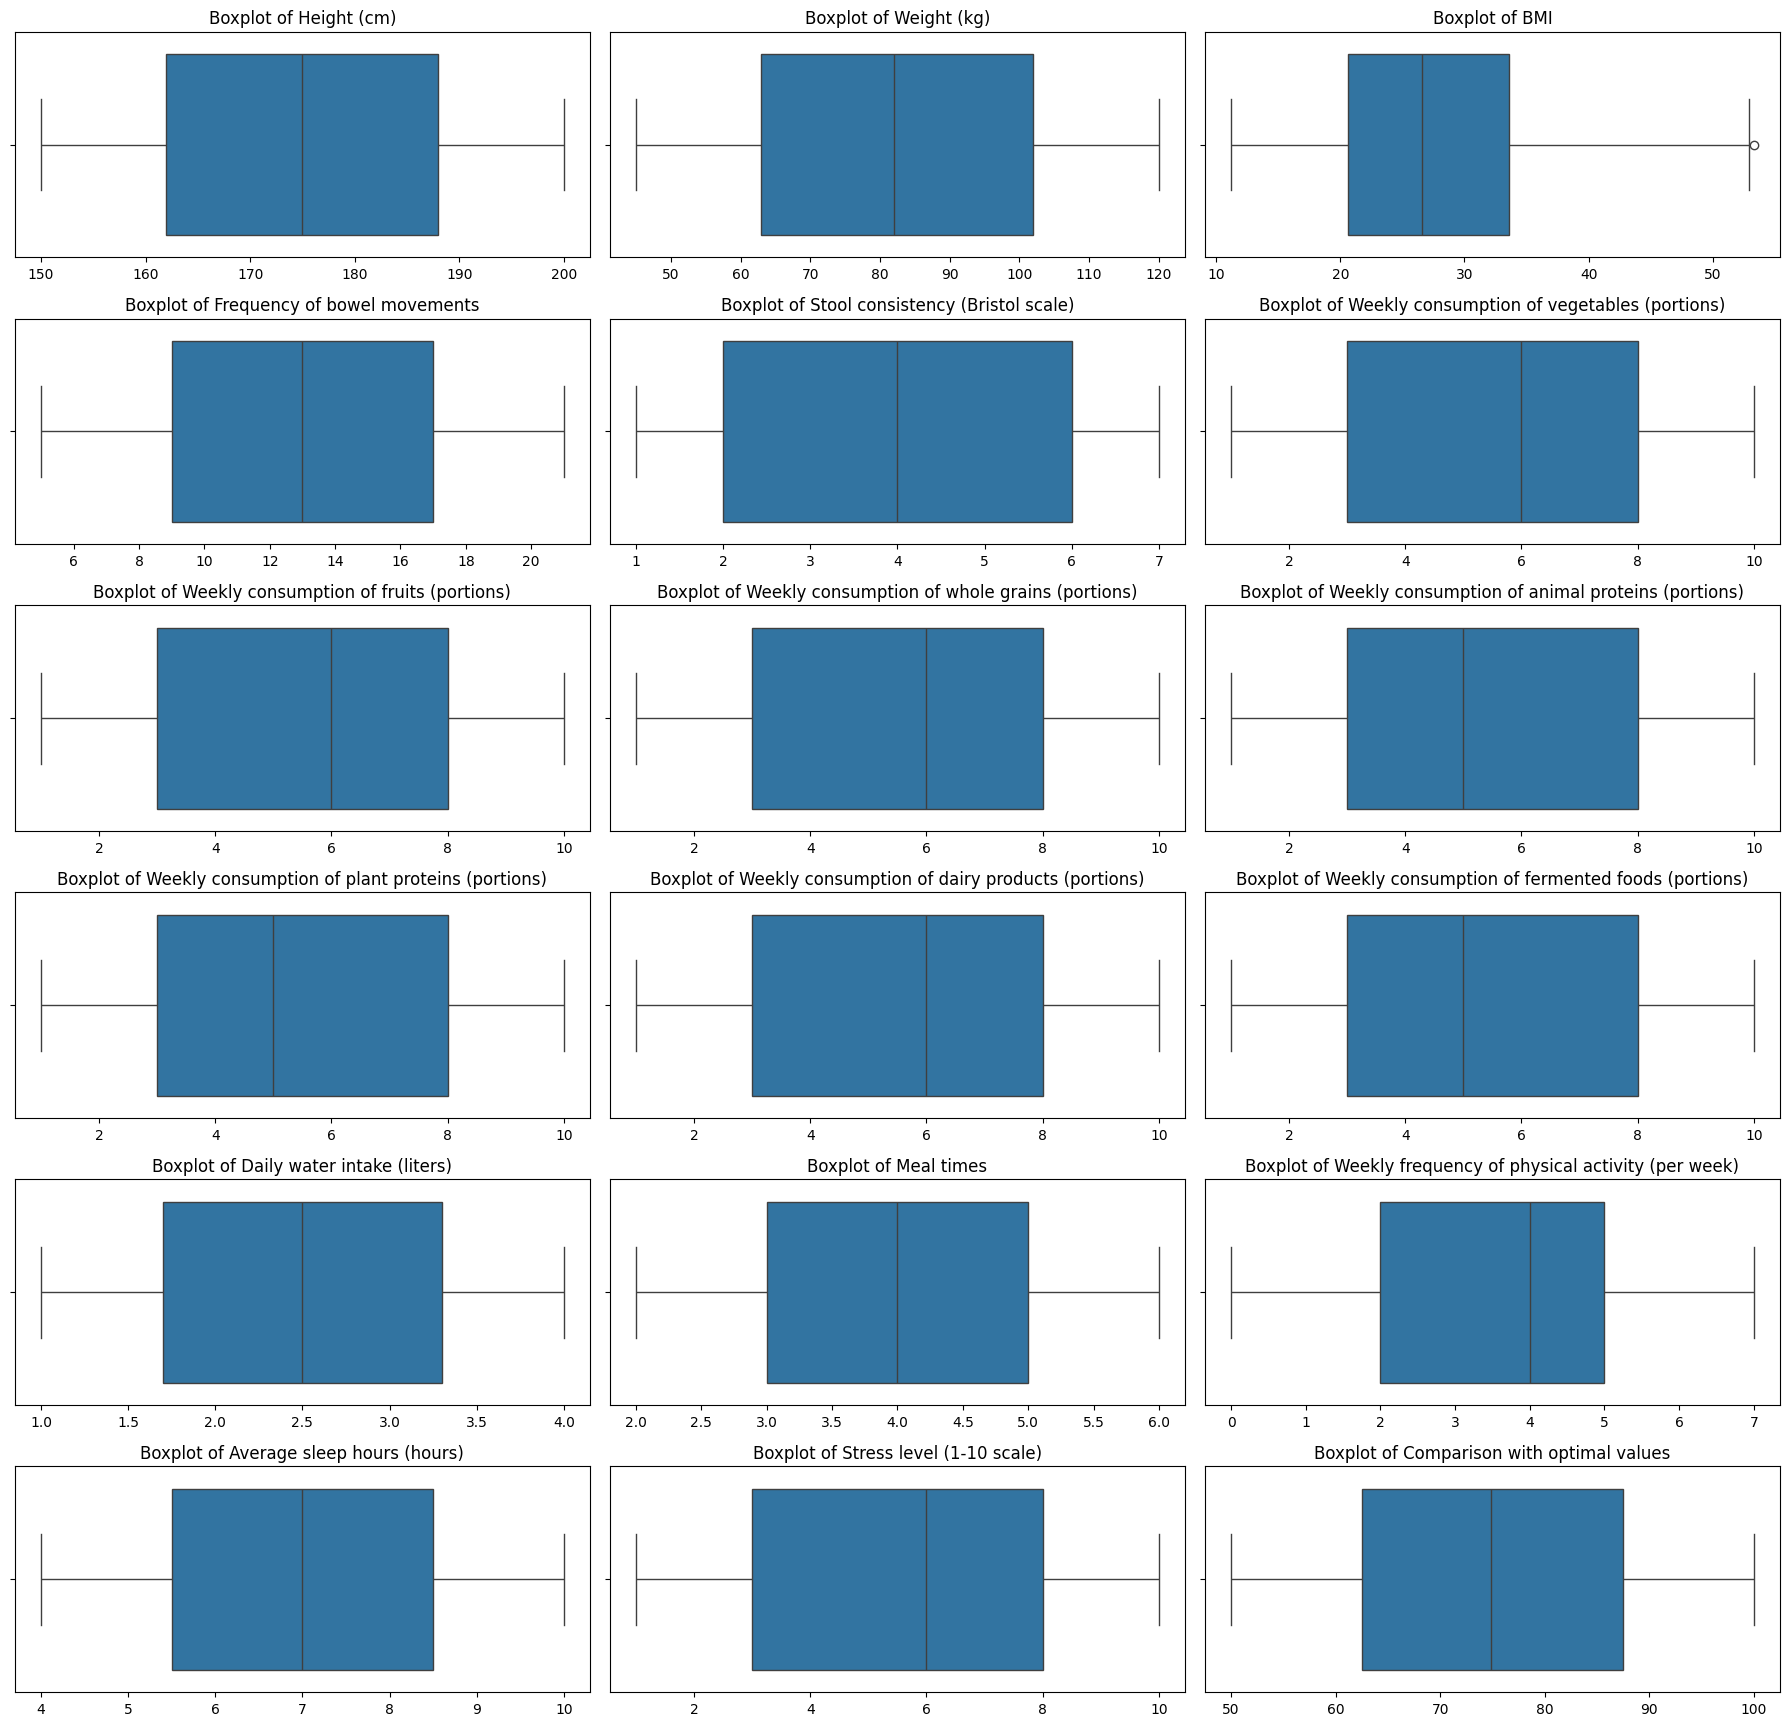

,0


In [5]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Identify numerical features for outlier detection
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots to detect outliers in numerical features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(numerical_features) // 3 + 1, ncols=3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel("")

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

missing_values


Identify class imbalance

<ipython-input-6-17d3fcb4a802>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


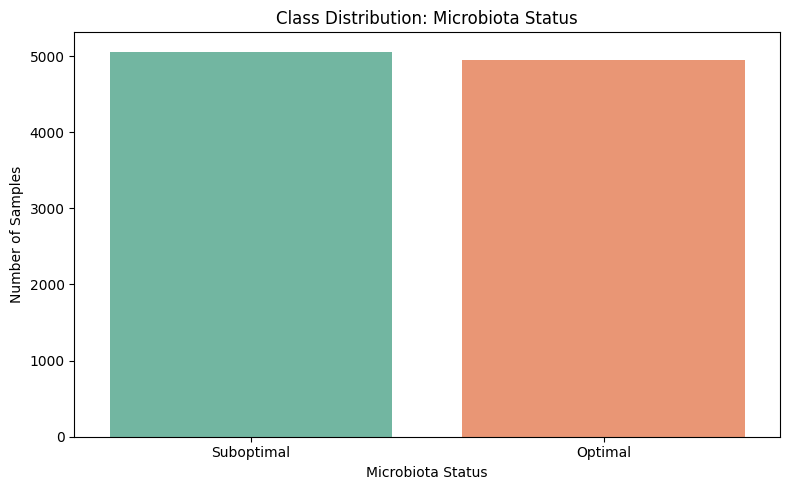

,count
Current status of microbiota,
Suboptimal,5058
Optimal,4942


In [6]:
# Count occurrences of each class in the target variable
class_counts = df['Current status of microbiota'].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution: Microbiota Status")
plt.xlabel("Microbiota Status")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# Display class counts
class_counts


✅ No missing values detected in the dataset — all features are complete.

This means we can skip imputation/removal and move directly to the next preprocessing step.

In [7]:
# Check for missing values again to confirm
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

# Since the previous check showed no missing values, we expect an empty result
missing_summary


,0


Encode categorical variables (e.g., Label Encoding, One-Hot Encoding)

In [18]:
from sklearn.preprocessing import LabelEncoder

# Drop high-cardinality or non-informative columns before encoding
columns_to_drop = [
    'Residential Address',
    'Supplement Plan - Recommended products',
    'Supplement Plan - Dosages and timings',
    'Meal Plan - Recommended/avoided foods',
    'Weekly menu',
    'Personalized recipes'
]

df_reduced = df.drop(columns=columns_to_drop)

# Categorical features excluding target
categorical_features = df_reduced.select_dtypes(include='object').columns
nominal_features = [col for col in categorical_features if col != 'Current status of microbiota']

# One-Hot Encoding for nominal features
df_encoded = pd.get_dummies(df_reduced, columns=nominal_features, drop_first=True)

# Label Encoding for target variable
label_encoder = LabelEncoder()
df_encoded['Microbiota_Status_Label'] = label_encoder.fit_transform(df['Current status of microbiota'])

# Drop original target column
df_encoded.drop(columns=['Current status of microbiota'], inplace=True)

# Show encoded dataframe shape and first few rows
print("Encoded dataset shape:", df_encoded.shape)
df_encoded.head()


Encoded dataset shape: (10000, 199)


,Height (cm),Weight (kg),BMI,Previous gastrointestinal issues,Frequency of bowel movements,Stool consistency (Bristol scale),Presence of bloating,Presence of gas,Presence of abdominal pain,Difficult digestion,...,"Relevant family history_Heart disease, Diabetes","Relevant family history_Heart disease, Hypertension","Relevant family history_Hypertension, Cancer","Relevant family history_Hypertension, Diabetes","Relevant family history_Hypertension, Heart disease",Other supplements_Multivitamins,Other supplements_Omega-3,Other supplements_Vitamin D,Intestinal health indicators_Suboptimal,Microbiota_Status_Label
0,173,120,40.1,True,6,2,False,True,False,True,...,False,False,False,False,False,False,False,False,False,0
1,183,110,32.8,False,18,6,True,True,True,True,...,False,False,True,False,False,True,False,False,True,1
2,160,111,43.4,False,6,6,False,True,False,True,...,False,False,False,False,True,False,True,False,False,1
3,177,75,23.9,True,16,7,True,False,True,False,...,False,False,False,False,False,False,True,False,False,0
4,170,97,33.6,True,17,4,True,False,False,True,...,False,False,False,False,False,False,True,False,False,0


In [19]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features to scale (excluding the label)
numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = [col for col in numerical_columns if col != 'Microbiota_Status_Label']

# Initialize scaler
scaler = StandardScaler()

# Apply standardization
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Display shape and first few rows
df_encoded[numerical_columns + ['Microbiota_Status_Label']].head()


,Height (cm),Weight (kg),BMI,Frequency of bowel movements,Stool consistency (Bristol scale),Weekly consumption of vegetables (portions),Weekly consumption of fruits (portions),Weekly consumption of whole grains (portions),Weekly consumption of animal proteins (portions),Weekly consumption of plant proteins (portions),Weekly consumption of dairy products (portions),Weekly consumption of fermented foods (portions),Daily water intake (liters),Meal times,Weekly frequency of physical activity (per week),Average sleep hours (hours),Stress level (1-10 scale),Comparison with optimal values,Microbiota_Status_Label
0,-0.126180,1.703746,1.413641,-1.420041,-1.015742,-1.578912,-1.209762,0.167708,-1.183528,-1.211541,-0.869057,-0.173437,1.378582,0.696159,-1.540825,-1.148490,0.172573,0.677198,0
1,0.547393,1.250452,0.591163,1.018321,0.976104,-0.538877,-0.862947,-1.203855,-0.838848,-0.165576,1.554801,1.568946,-0.229335,-0.713498,-1.540825,1.221807,0.172573,-0.297663,1
2,-1.001826,1.295781,1.785446,-1.420041,0.976104,0.154480,-0.516131,-0.175183,1.229232,1.577699,1.554801,-1.567343,-1.607550,-1.418327,1.088943,0.065565,0.875088,0.357583,1
3,0.143249,-0.336077,-0.411585,0.611927,1.474066,1.194515,1.564763,1.196380,-1.183528,1.229044,0.516005,-0.870390,-1.607550,1.400988,1.088943,-0.396932,0.523830,-0.778826,0
4,-0.328253,0.661170,0.681297,0.815124,-0.019819,1.194515,-0.862947,-0.860964,-1.528208,-0.862886,-0.522791,-0.870390,0.115219,-0.008669,1.527238,-1.264114,0.875088,0.141024,0


Derive composite metrics (e.g., Plant-to-Animal Protein Ratio)


In [28]:
# First, create the composite feature in the main DataFrame
df['Plant_to_Animal_Protein_Ratio'] = (
    df['Weekly consumption of plant proteins (portions)'] /
    (df['Weekly consumption of animal proteins (portions)'] + 1e-5)
)

# Then define the enriched feature list
enriched_features = [
    'Frequency of bowel movements',
    'Stool consistency (Bristol scale)',
    'Presence of bloating',
    'Presence of gas',
    'Presence of abdominal pain',
    'Difficult digestion',
    'Previous gastrointestinal issues',
    'Weekly consumption of fermented foods (portions)',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Daily water intake (liters)',
    'Alcohol consumption',
    'Recent use of antibiotics',
    'Probiotics', 'Prebiotics', 'Vitamins', 'Minerals', 'Other supplements',
    'Plant_to_Animal_Protein_Ratio',
    'BMI', 'Average sleep hours (hours)', 'Stress level (1-10 scale)',
    'Weekly frequency of physical activity (per week)',
    'Current status of microbiota'  # Target variable
]

# Subset the DataFrame only after ensuring all features exist
df_enriched = df[enriched_features].dropna()


In [29]:
df_enriched

,Frequency of bowel movements,Stool consistency (Bristol scale),Presence of bloating,Presence of gas,Presence of abdominal pain,Difficult digestion,Previous gastrointestinal issues,Weekly consumption of fermented foods (portions),Weekly consumption of vegetables (portions),Weekly consumption of fruits (portions),...,Prebiotics,Vitamins,Minerals,Other supplements,Plant_to_Animal_Protein_Ratio,BMI,Average sleep hours (hours),Stress level (1-10 scale),Weekly frequency of physical activity (per week),Current status of microbiota
0,6,2,False,True,False,True,True,5,1,2,...,False,True,False,Magnesium,0.999995,40.1,5.0,6,0,Optimal
1,18,6,True,True,True,True,False,10,4,3,...,False,False,False,Multivitamins,1.666661,32.8,9.1,6,0,Suboptimal
2,6,6,False,True,False,True,False,1,6,4,...,True,False,True,Omega-3,1.111110,43.4,7.1,8,6,Suboptimal
3,16,7,True,False,True,False,True,3,9,10,...,True,False,True,Omega-3,4.499978,23.9,6.3,7,6,Optimal
4,17,4,True,False,False,True,True,3,9,3,...,False,True,True,Omega-3,2.999970,33.6,4.8,8,7,Optimal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15,6,True,True,True,True,True,9,3,8,...,True,True,True,Magnesium,2.999990,30.6,4.2,5,0,Suboptimal
9996,19,6,False,True,True,False,False,7,2,8,...,False,False,False,Vitamin D,4.999975,22.6,7.3,3,0,Suboptimal
9997,13,4,True,False,False,False,True,4,8,3,...,False,False,False,Multivitamins,1.124999,33.9,6.8,7,5,Optimal
9998,9,2,False,True,True,False,False,3,2,2,...,True,False,True,Omega-3,6.999930,44.9,4.7,2,7,Optimal


Convert ordinal data to bins (e.g., stress level)


In [21]:
# Copy dataset for feature engineering
df_fe_binned = df_fe.copy()

# Convert "Stress level (1-10 scale)" into ordinal bins
# Define bins and labels
stress_bins = [0, 3, 6, 10]
stress_labels = ['Low', 'Moderate', 'High']

# Create binned column
df_fe_binned['Stress_Level_Binned'] = pd.cut(
    df_fe_binned['Stress level (1-10 scale)'],
    bins=stress_bins,
    labels=stress_labels,
    include_lowest=True
)

# Show distribution of binned stress levels
df_fe_binned['Stress_Level_Binned'].value_counts()


,count
Stress_Level_Binned,
High,4017
Moderate,3024
Low,2959


Highlight gut health-related features using domain knowledge


In [23]:
# Define key gut health-related features
gut_health_features = [
    'Frequency of bowel movements',
    'Stool consistency (Bristol scale)',
    'Presence of bloating',
    'Presence of gas',
    'Presence of abdominal pain',
    'Difficult digestion',
    'Previous gastrointestinal issues',
    'Weekly consumption of fermented foods (portions)',
    'Weekly consumption of vegetables (portions)',
    'Weekly consumption of fruits (portions)',
    'Weekly consumption of whole grains (portions)',
    'Plant_to_Animal_Protein_Ratio',
    'Daily water intake (liters)',
    'Alcohol consumption',
    'Recent use of antibiotics',
    'Probiotics',
    'Prebiotics',
    'Vitamins',
    'Minerals',
    'Other supplements',
    'Current status of microbiota'  # Target
]

# Extract relevant features
df_gut_health = df_fe_binned[gut_health_features].copy()

# Display basic information
print("Gut health feature set shape:", df_gut_health.shape)
print(df_gut_health.head())


Gut health feature set shape: (10000, 21)
   Frequency of bowel movements  Stool consistency (Bristol scale)  \
0                             6                                  2   
1                            18                                  6   
2                             6                                  6   
3                            16                                  7   
4                            17                                  4   

   Presence of bloating  Presence of gas  Presence of abdominal pain  \
0                 False             True                       False   
1                  True             True                        True   
2                 False             True                       False   
3                  True            False                        True   
4                  True            False                       False   

   Difficult digestion  Previous gastrointestinal issues  \
0                 True                      

Step 4: Model Creation